# Trash Classification

## Data Preparation

### Mount Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Trash Classification Project'

/content/drive/MyDrive/Trash Classification Project


In [ ]:
directory = '/content/drive/MyDrive/Trash Classification Project'

In [ ]:
data_path = os.path.join(directory, 'trashnet')

### Load, Split and Transform Data

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
dataset = ImageFolder(data_path)
classes = dataset.classes

In [ ]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [ ]:
test_ratio = 0.2
total_samples = len(dataset)
test_samples = int(test_ratio * total_samples)
train_samples = total_samples - test_samples

In [ ]:
trainset, testset = random_split(dataset, [train_samples, test_samples])

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
train_data = MyDataset(trainset, transform=train_transform)
test_data = MyDataset(testset, transform=test_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, num_workers=2)

## Data Visualization

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

In [ ]:
def show(img, labels):
  str_labels = [classes[i] for i in labels]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.title(' '.join(str_labels))
  plt.show()

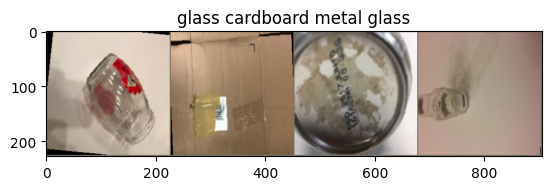

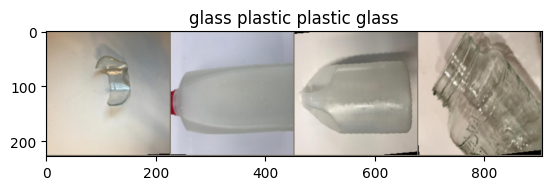

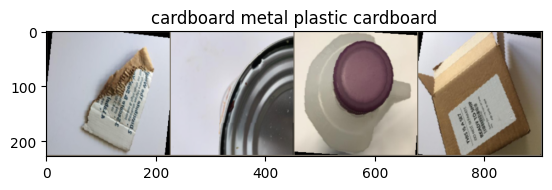

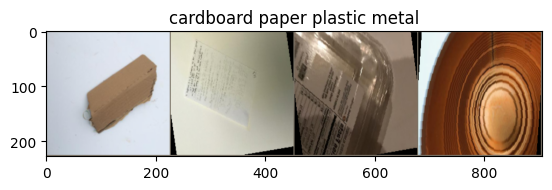

In [ ]:
show(make_grid(images[:4]), labels[:4])
show(make_grid(images[4:8]), labels[4:8])
show(make_grid(images[8:12]), labels[8:12])
show(make_grid(images[12:]), labels[12:])

In [ ]:
def count_data(loader, counter):
  for data in loader:
    images, labels = data
    for label in labels:
      counter[classes[label]] += 1
  return counter

In [ ]:
train_count = {name: 0 for name in classes}
test_count = {name: 0 for name in classes}

In [ ]:
print('Train Count: ', count_data(train_loader, train_count))
print('Test Count: ', count_data(test_loader, test_count))

Train Count:  {'cardboard': 334, 'glass': 417, 'metal': 324, 'paper': 472, 'plastic': 374}
Test Count:  {'cardboard': 69, 'glass': 84, 'metal': 97, 'paper': 122, 'plastic': 108}


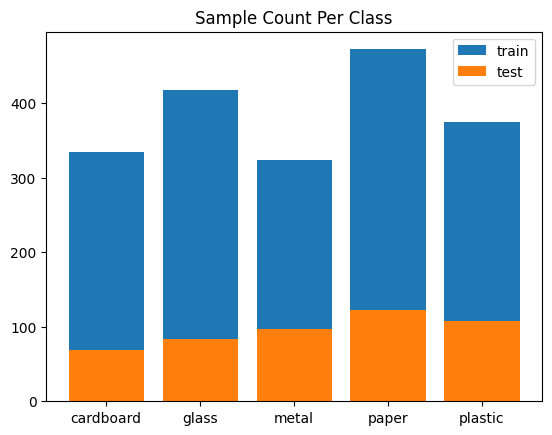

In [ ]:
plt.bar(list(train_count.keys()), list(train_count.values()), label='train')
plt.bar(list(test_count.keys()), list(test_count.values()), label='test')
plt.title('Sample Count Per Class')
plt.legend()
plt.show()

## Build Model Architecture

**MobileNet Fine Tuning**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
def build_model():
  model = mobilenet_v2(MobileNet_V2_Weights.DEFAULT)
  model.classifier[-1] = nn.Linear(model.last_channel, len(classes))
  return model

In [ ]:
model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 6.73MB/s]


## Training Model (With GPU)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


In [ ]:
def train_engine(train_loader, test_loader, model, criterion, optimizer, 
                 checkpoint_path, num_epochs=30, early_stopping_patience=5, device="cpu"):
    """
    Train engine function for PyTorch models with checkpointing and early stopping callbacks.

    Args:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the test set.
    - model (nn.Module): PyTorch model to be trained.
    - criterion (nn.Module): PyTorch loss function.
    - optimizer (nn.Module): PyTorch optimizer.
    - checkpoint_path (str): Path to save the model checkpoints.
    - early_stopping_patience (int): Number of epochs to wait for the validation loss to improve before stopping early.
    - device (str): Device to use for training ("cpu" or "cuda").

    Returns:
    - best_epoch (int): The epoch with the best validation loss.
    - best_val_loss (float): The best validation loss achieved during training.
    """

    # Move the model and loss function to the specified device
    model.to(device)
    criterion.to(device)

    # Initialize variables for early stopping
    best_val_loss = float("inf")
    val_losses = []
    no_improvement_epochs = 0

    # Train the model for a fixed number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for inputs, labels in train_loader:
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for inputs, labels in test_loader:
                # Move the inputs and labels to the specified device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate the loss
                total_loss += loss.item()

            # Compute the average validation loss
            avg_val_loss = total_loss / len(test_loader)
            val_losses.append(avg_val_loss)

            # Print the current epoch and validation loss
            print(f"Epoch {epoch+1}/{num_epochs}: Validation loss = {avg_val_loss:.4f}")

            # Checkpoint the model if the validation loss has improved
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_epochs = 0
                torch.save(model.state_dict(), checkpoint_path)
                print('Validation Loss Improved. Saving Best Model.')
            else:
                no_improvement_epochs += 1

            # Stop early if the validation loss has not improved for a fixed number of epochs
            if no_improvement_epochs >= early_stopping_patience:
                print(f"Validation loss has not improved for {early_stopping_patience} epochs. Stopping early.")
                return val_losses, best_val_loss

    return val_losses, best_val_loss


In [ ]:
val_losses, best_val_loss = train_engine(train_loader, test_loader, model, criterion, optimizer, 
                                         'model.pth', device=device)

Epoch 1/30: Validation loss = 0.4981
Validation Loss Improved. Saving Best Model.
Epoch 2/30: Validation loss = 0.5751
Epoch 3/30: Validation loss = 0.5058
Epoch 4/30: Validation loss = 0.4934
Validation Loss Improved. Saving Best Model.
Epoch 5/30: Validation loss = 0.3224
Validation Loss Improved. Saving Best Model.
Epoch 6/30: Validation loss = 0.3465
Epoch 7/30: Validation loss = 0.8984
Epoch 8/30: Validation loss = 0.4042
Epoch 9/30: Validation loss = 0.3413
Epoch 10/30: Validation loss = 0.4329
Validation loss has not improved for 5 epochs. Stopping early.


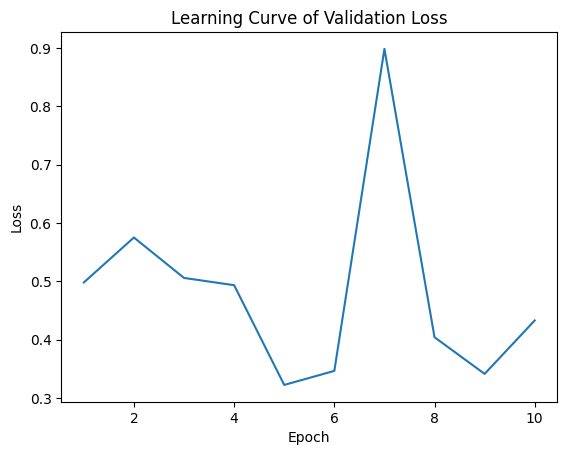

In [ ]:
plt.plot(range(1, len(val_losses)+1), val_losses)
plt.title('Learning Curve of Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model Evaluation

In [ ]:
import torch.nn.functional as F

In [ ]:
model = build_model()
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
data_iterator = iter(test_loader)
images, labels = next(data_iterator)

In [ ]:
outputs = model(images)
probabilities = F.softmax(outputs, dim=1)
print(probabilities)
_, predictions = torch.max(probabilities, 1)
print(predictions)

tensor([[4.4389e-04, 1.3585e-03, 9.4629e-01, 1.5271e-03, 5.0385e-02],
        [1.4447e-04, 9.4496e-01, 2.5401e-02, 9.0907e-05, 2.9403e-02],
        [9.9484e-01, 3.9558e-03, 7.4007e-04, 2.7996e-04, 1.8487e-04],
        [6.5620e-05, 9.9268e-01, 5.9682e-03, 5.5828e-04, 7.2755e-04],
        [3.6267e-05, 2.9482e-03, 3.7107e-02, 9.1498e-01, 4.4931e-02],
        [3.9125e-05, 1.5224e-01, 1.6101e-04, 1.0725e-04, 8.4745e-01],
        [3.0329e-04, 1.0527e-05, 2.5314e-07, 9.9961e-01, 7.2522e-05],
        [2.9274e-06, 5.2935e-01, 4.7046e-01, 8.0479e-05, 1.1002e-04],
        [4.3915e-06, 2.3238e-06, 4.3454e-06, 9.9999e-01, 2.4247e-06],
        [2.9392e-01, 1.1063e-02, 1.4332e-02, 6.7452e-01, 6.1666e-03],
        [5.4970e-05, 9.1701e-01, 1.0060e-02, 5.0097e-04, 7.2376e-02],
        [9.1751e-04, 7.0389e-01, 2.5803e-01, 6.2991e-03, 3.0859e-02],
        [1.1119e-04, 3.4450e-02, 3.4465e-02, 3.0926e-04, 9.3066e-01],
        [4.3431e-04, 5.5847e-01, 7.3897e-04, 1.3561e-03, 4.3900e-01],
        [9.9969e-01,

In [ ]:
def show(img, labels, preds):
  str_labels = [classes[i] for i in labels]
  str_preds = [classes[j] for j in preds]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.show()
  print('Ground Truth: ', ' '.join(str_labels))
  print('Predictions: ', ' '.join(str_preds))

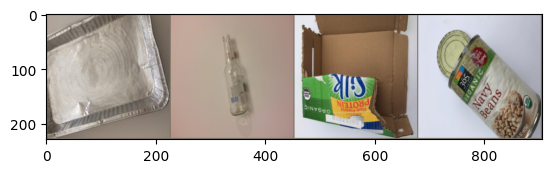

Ground Truth:  metal glass cardboard metal
Predictions:  metal glass cardboard glass


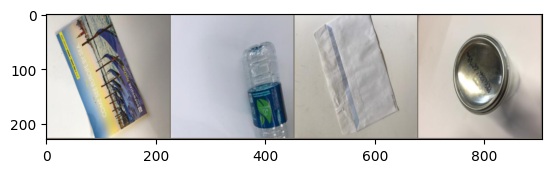

Ground Truth:  paper plastic paper metal
Predictions:  paper plastic paper glass


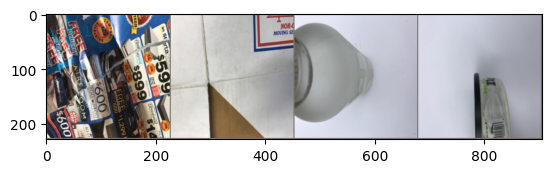

Ground Truth:  paper cardboard glass plastic
Predictions:  paper paper glass glass


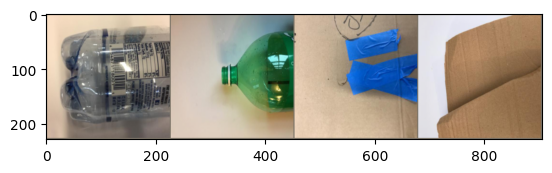

Ground Truth:  plastic plastic cardboard cardboard
Predictions:  plastic glass cardboard cardboard


In [ ]:
show(make_grid(images[:4]), labels[:4], predictions[:4])
show(make_grid(images[4:8]), labels[4:8], predictions[4:8])
show(make_grid(images[8:12]), labels[8:12], predictions[8:12])
show(make_grid(images[12:]), labels[12:], predictions[12:])

In [ ]:
correct_pred = {name: 0 for name in classes}
total_pred = {name: 0 for name in classes}

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    for label, pred in zip(labels, predictions):
      if label == pred:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
  class_acc = (correct_count/total_pred[class_name]) * 100
  print(f'[Accuracy for class: {class_name}]: {round(class_acc, 2)}')

total_correct = 0
for count in correct_pred.values():
  total_correct += count
test_acc = (total_correct/len(test_data)) * 100
print(f'Testing Accuracy: {round(test_acc, 2)} %')

[Accuracy for class: cardboard]: 89.86
[Accuracy for class: glass]: 91.67
[Accuracy for class: metal]: 72.16
[Accuracy for class: paper]: 89.34
[Accuracy for class: plastic]: 75.93
Testing Accuracy: 83.33 %
